## Notebook for Figure 2

In [1]:
%matplotlib inline

import os

import xarray as xr
import numpy as np
import requests

#Plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

from one_pass.opa import Opa

Load data - this is the raw daily data spanning one year at 0.25 degree resolution. Avaliable on Zenodo.

In [2]:
# Download data if not present
url = "https://zenodo.org/records/12533197/files/ssh_2021_FESOM_tco2559_ng5_cycle3_r025.nc?download=1"
filename = "ssh_2021.nc"

if not os.path.isfile(filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

# Load data
ssh_2021 = xr.open_dataset(filename)
ssh_2021 = ssh_2021.fillna(0)

In [3]:
ssh_2021

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 365, lat: 720, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2021-01-01T23:56:00 ... 2021-12-31T23:...
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    ssh      (time, lat, lon) float64 3GB 0.0 0.0 0.0 ... -0.5926 -0.5926

Calculate conventional standard deviation

In [4]:
ssh_2021_std = ssh_2021.std(dim = 'time', ddof = 1)
ssh_2021_std

<xarray.Dataset> Size: 8MB
Dimensions:  (lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Data variables:
    ssh      (lat, lon) float64 8MB 0.0 0.0 0.0 0.0 ... 0.04734 0.04734 0.04734

Use the functions imported from the algorithms script to calculate the annual standard deviation. They provide the code implementation of the algorithm descriptions provided in the paper.

Here, we simulate data streaming by looping through the full data set. This is possible due to the lower resolution of the global data (we have interpolated from native 0.05 degree to 0.25 degree), however if the data was higher (e.g. native 0.05 degree) spatial resolution, having the full data set in memory would be challenging. These algorithms are designed to be used in the context of a streaming workflow, where the data produced from global climate models is passed chunk by chunk.

$$
M_{i+1} = g(M_i, x)
$$

In [5]:
step = 2
# current number of data samples passed to the statistic
n = 0

# number of time steps required to complete the statistic
c = len(ssh_2021.time) # 365

opa_stat = Opa({
    "variable": "ssh",
    "stat": "std",
    "stat_freq": "yearly",
    "output_freq": "yearly",
    "time_step": 60,  # minutes
    "checkpoint": False,
    "save": False,
})

# Silence warnings
opa_stat.logger.setLevel("CRITICAL")

for day in range(0, c, step):
    
    # simulating the streamed data
    incoming_data_chunk = ssh_2021.ssh.isel(time = slice(day, day+step))

    # result is only a Data Array after the last incoming data chunk
    result = opa_stat.compute(incoming_data_chunk)
    
result

<xarray.DataArray 'ssh' (time: 1, lat: 720, lon: 1440)> Size: 8MB
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.60805652, -0.60818816, -0.60827281, ..., -0.60757999,
         -0.60777499, -0.60790804],
        [-0.60194615, -0.60198706, -0.60202401, ..., -0.60175516,
         -0.601836  , -0.60189534],
        [-0.59258189, -0.59258807, -0.5925942 , ..., -0.59256294,
         -0.59256933, -0.59257565]]], shape=(1, 720, 1440))
Coordinates:
  * time     (time) datetime64[ns] 8B 2021-12-31T23:56:00
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    description:  sea surface elevation
    long_name:    sea surface elevation
    units:        m
    regridded:    1
    history:      \n2024-03-15 17:46:35 AQUA💧: Regrid from ng5-nodes-2d to r0...

Now plot the Figure

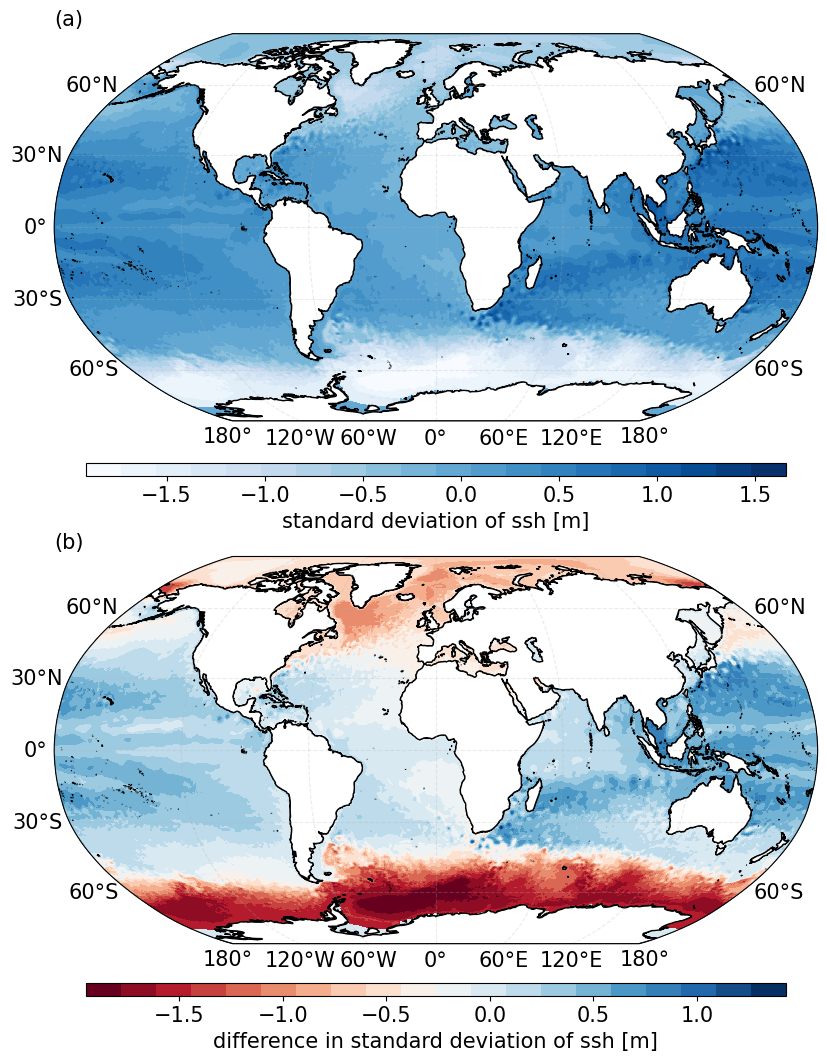

In [6]:
data_crs = ccrs.Robinson() #Projection.
fig = plt.figure(constrained_layout=False,figsize=(20,13))
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, hspace = 0.4)
nrow = 2
ncol = 1
outer = gs.GridSpec(nrow,ncol,wspace=0.01,hspace=0.35) # this one makes a diff
fsize = 15

# data to plot
# one-pass calculation 
one_pass_data = result.values[0,:,:]
# conventional calculation
two_pass_data = ssh_2021_std.ssh
# difference between the two
difference = one_pass_data - two_pass_data

for i in range(nrow*ncol):
    ax = plt.subplot(outer[i],projection = data_crs)
    ax.coastlines(resolution = '10m') #Draws the coastline.

    # Add land mask
    ax.add_feature(cfeature.LAND)
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='white')
    ax.add_feature(land_50m)
    gl = ax.gridlines(draw_labels = True,linestyle='dashed',alpha=0.25) #Draws meridians and parallels.
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': fsize}
    gl.ylabel_style = {'size': fsize}

    lon2d,lat2d = np.meshgrid(two_pass_data.lon, two_pass_data.lat)
    
    cmap = plt.get_cmap('Blues', 20)
    cmap1 = plt.get_cmap('RdBu', 20)
    
    if i == 0:
        cs = ax.pcolormesh(lon2d, lat2d, one_pass_data,transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(a)', fontsize = fsize, loc = 'left')

    else: 
        cs = ax.pcolormesh(lon2d, lat2d, difference, transform=ccrs.PlateCarree(),cmap=cmap1)
        ax.add_feature(cfeature.LAND, color='white')
        ax.set_title('(b)', fontsize = fsize, loc = 'left')

    # Add color bar for each subplot
    spacing = 0.4
    y_dis = 0.56 - i * (spacing)
    cbar_ax = fig.add_axes([0.325, y_dis, 0.35, 0.01])  # Adjust the positions for colorbars

    if i == 0:
        cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
        cbar.set_label("standard deviation of ssh [m]", rotation=0, fontsize = fsize)
        cbar.ax.tick_params(labelsize=fsize)
        
    else:
        cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal')
        cbar.set_label("difference in standard deviation of ssh [m]", rotation=0, fontsize = fsize)
        cbar.ax.tick_params(labelsize=fsize)

# Set the font size of colorbar tick labels and numeric values
cbar.ax.tick_params(axis='x', labelsize=fsize)
cbar.update_ticks()

plt.show()